# Setup and Load Data

In [4]:
!pip --version
!python --version

pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Python 3.10.12


In [5]:
!pip install opencv-python matplotlib

In [6]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.34.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.16
albumentations                   1.4.15
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.19.0
astropy                          6.1.3
astropy-iers-data                0.2024.9.16.0.32.21
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread                        3.0.1
autograd               

In [7]:
import tensorflow as tf
import os

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[]

# Remove Dodgy Images

In [10]:
import cv2
import imghdr

In [14]:
data_dir = '/content/sample_data/data'

In [15]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [19]:
data = tf.keras.utils.image_dataset_from_directory('/content/sample_data/data')

Found 305 files belonging to 2 classes.


In [20]:
data_iterator = data.as_numpy_iterator()

In [21]:
batch = data_iterator.next()

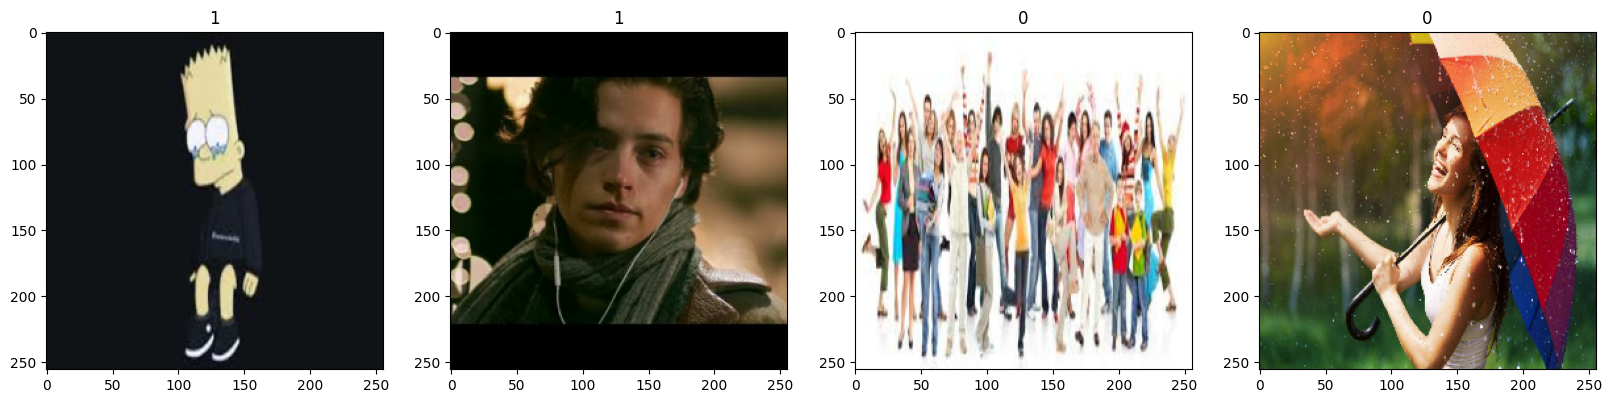

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale Data

In [23]:
data = data.map(lambda x,y: (x/255, y))

In [24]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

# Split Data

In [25]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [27]:
train_size

7

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Build Deep Learning Model

In [29]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [31]:
model = Sequential()

In [32]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [35]:
logdir='logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5171 - loss: 0.7105 - val_accuracy: 0.5312 - val_loss: 0.6389
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5957 - loss: 0.6203 - val_accuracy: 0.8594 - val_loss: 0.4773
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8107 - loss: 0.5273 - val_accuracy: 0.8594 - val_loss: 0.3809
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7992 - loss: 0.4812 - val_accuracy: 0.8281 - val_loss: 0.3919
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8842 - loss: 0.3701 - val_accuracy: 0.9531 - val_loss: 0.3092
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8736 - loss: 0.3428 - val_accuracy: 0.8594 - val_loss: 0.2948
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9155 - loss: 0.2339 - val_accuracy: 0.9844 - val_loss: 0.1382
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9531 - loss: 0.1677 - val_accuracy: 0.9688 - val_loss: 0.0890
Epoch 9/

# Plot Performance

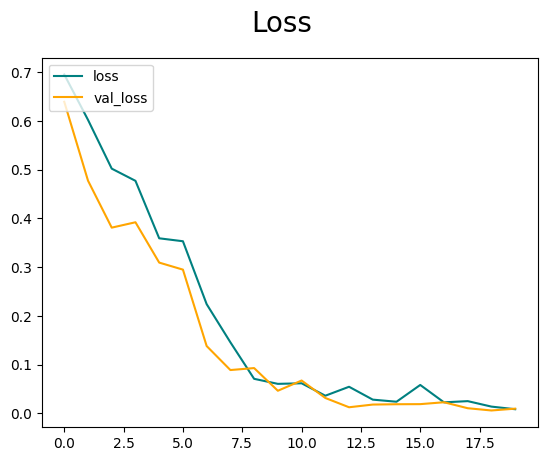

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

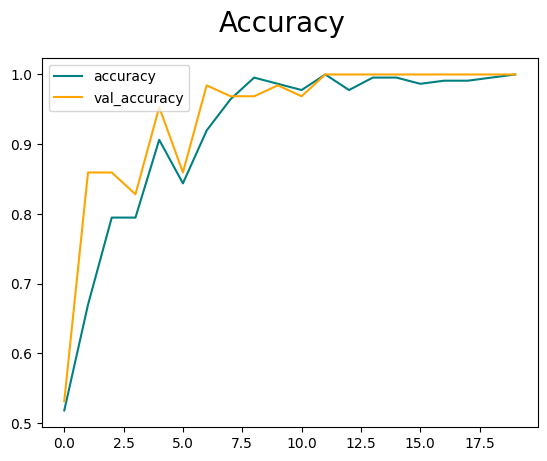

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Model

In [40]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


In [43]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# Test the Model

In [44]:
import cv2

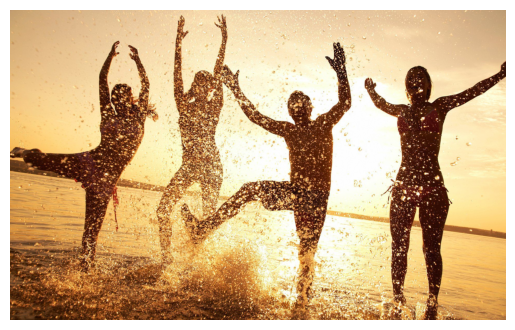

In [47]:
# Load the image using OpenCV
img = cv2.imread('/content/sample_data/data/happy/1902539.jpg')

# Check if the image was loaded successfully
if img is not None:
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Image not found or could not be loaded.")

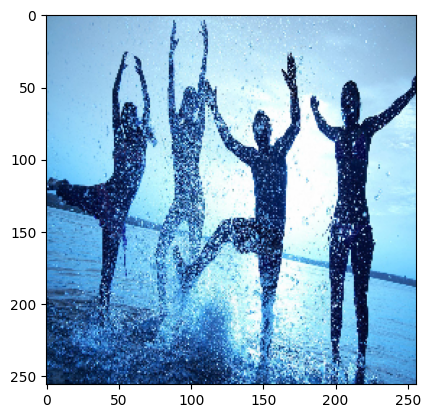

In [48]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


In [50]:
yhat

array([[0.00039834]], dtype=float32)

In [51]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
